# Air Quality Analysis
## Contributor: Sam Espe
---

This is a self-guided project to look into EPA air quality data.

#### Functions

In [1]:
#Import dependencies

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Generalize processing raw CSV

def clean_data(raw_csv_path):
    # Clear variables
    column_names = []
    
    # Read in raw data
    data_path = raw_csv_path
    raw_dataframe = pd.read_csv(raw_csv_path)
    
    # Drop unnecessary columns
    raw_df_dropped = raw_dataframe.drop(columns = ["Source", "Site ID", "DAILY_OBS_COUNT", "PERCENT_COMPLETE", 
                                                   "AQS_PARAMETER_CODE", "AQS_PARAMETER_DESC", "CBSA_CODE", 
                                                   "CBSA_NAME", "COUNTY_CODE", "STATE_CODE", "STATE"])
    
    # Rename columns
    column_names = {"Date": "Date", "POC": "POC", "Daily Mean PM2.5 Concentration": "Day_Mean_PM25_Conc", "UNITS": "Units", 
           "DAILY_AQI_VALUE":"Daily_AQI", "Site Name": "Site_Name", "COUNTY": "County", "SITE_LATITUDE": "Latitude",
          "SITE_LONGITUDE": "Longitude"}
    
    raw_df_renamed = raw_df_dropped.rename(columns = column_names)
    
    # Change date column to datetime 
    raw_df_renamed["Date"] = pd.to_datetime(raw_df_renamed["Date"])
    
    # Add "AQI_Concern" column to reflect AQI category names
    raw_df_renamed["AQI_Concern"] = np.where(raw_df_renamed["Daily_AQI"] <= 50, "Good", 
                                                     np.where(raw_df_renamed["Daily_AQI"] <= 100, "Moderate", 
                                                              np.where(raw_df_renamed["Daily_AQI"] <= 150, "Unhealthy for Sensitive Groups", 
                                                                       np.where(raw_df_renamed["Daily_AQI"] <= 200, "Unhealthy", 
                                                                                np.where(raw_df_renamed["Daily_AQI"] <= 300, "Very Unhealthy", "Hazardous")))))
    
    return raw_df_renamed 

In [3]:
# Generalize separating location data and identifying POC with most data

def data_split(raw_df_name, state, pollutant_name, year):
    # Clear variables
    location_list = []
    data_dict = {}
    
    # Create list of unique locations
    location_list = raw_df_name["Site_Name"].unique().tolist()
    for location in location_list:
        location_df = raw_df_name.loc[raw_df_name["Site_Name"] == location]
        poc_list_location = dict(location_df.value_counts("POC"))
    
        # Choose POC with most data
        if len(poc_list_location) > 1:
            location_df = location_df.loc[location_df["POC"] == max(poc_list_location, key = poc_list_location.get)]
    
        location_standard_name = location.replace(' ', '_').replace('/', "_").replace(":", "").replace("-", "").replace(".", "")
        new_name = f"{location_standard_name}_{state}_{pollutant_name}_{year}"
        data_dict[new_name] = location_df
        
    return data_dict

In [4]:
# Generalize the color-coded scatter plot process

def scatter_plot_color(df_name, pollutant_name, location_name, year):
    moderate_bound = 50
    unhealthy_for_special_groups_bound = 100
    unhealthy_bound = 150
    very_unhealthy_bound = 200
    hazardous_bound = 300

    x_values = df_name["Date"]
    y_values = df_name["Daily_AQI"]
    
    good = np.ma.masked_where(y_values > moderate_bound, y_values)
    moderate = np.ma.masked_where((y_values <= moderate_bound) | (y_values > unhealthy_for_special_groups_bound), y_values)
    unhealthy_special_groups = np.ma.masked_where((y_values <= unhealthy_for_special_groups_bound) | (y_values > unhealthy_bound), y_values)
    unhealthy = np.ma.masked_where((y_values <= unhealthy_bound) | (y_values > very_unhealthy_bound), y_values)
    very_unhealthy = np.ma.masked_where((y_values <= very_unhealthy_bound) | (y_values > hazardous_bound), y_values)
    hazardous = np.ma.masked_where(y_values <= hazardous_bound, y_values)
    
    fig, ax = plt.subplots()
    ax.scatter(x_values, good, color = 'green', marker = '.')
    ax.scatter(x_values, moderate, color = 'yellow', marker = '.')
    ax.scatter(x_values, unhealthy_special_groups, color = 'orange', marker = '.')
    ax.scatter(x_values, unhealthy, color = 'red', marker = '.')
    ax.scatter(x_values, very_unhealthy, color = 'purple', marker = '.')
    ax.scatter(x_values, hazardous, color = 'maroon', marker = '.')

    plt.xlabel("Date")
    plt.ylabel("Air Quality Index")
    plt.title(f'{pollutant_name} AQI for {location_name} in {year}')
    
    plt.show()

#### MN PM 2.5 data for 2022

In [5]:
# Clean data for 2022
mn_pm25_2022 = clean_data("Data/2022_MN_PM_25.csv")

In [6]:
# Split data for 2022
mn_pm25_2022_dict = data_split(mn_pm25_2022, "MN", "PM_2_5", 2022)
mn_pm25_2022_dict

{'Anoka_County_Airport_MN_PM_2_5_2022':           Date  POC  Day_Mean_PM25_Conc     Units  Daily_AQI  \
 119 2022-01-01    3                 9.6  ug/m3 LC         40   
 120 2022-01-02    3                13.3  ug/m3 LC         54   
 121 2022-01-03    3                11.7  ug/m3 LC         49   
 122 2022-01-04    3                14.5  ug/m3 LC         56   
 123 2022-01-05    3                 3.9  ug/m3 LC         16   
 ..         ...  ...                 ...       ...        ...   
 463 2022-12-19    3                 9.8  ug/m3 LC         41   
 464 2022-12-20    3                 7.0  ug/m3 LC         29   
 465 2022-12-21    3                 8.0  ug/m3 LC         33   
 466 2022-12-22    3                 4.3  ug/m3 LC         18   
 467 2022-12-31    3                 6.1  ug/m3 LC         25   
 
                 Site_Name County  Latitude  Longitude AQI_Concern  
 119  Anoka County Airport  Anoka  45.13768 -93.207615        Good  
 120  Anoka County Airport  Anoka  45.137

In [7]:
# Get keys for dictionary
mn_pm25_2022_locations = list(mn_pm25_2022_dict.keys())
mn_pm25_2022_locations

['Anoka_County_Airport_MN_PM_2_5_2022',
 'FWS_Wetland_Management_District_MN_PM_2_5_2022',
 'Red_Lake_Nation_MN_PM_2_5_2022',
 'Fond_du_Lac_Band_MN_PM_2_5_2022',
 'Leech_Lake_Nation_MN_PM_2_5_2022',
 'Grand_Portage_Band_MN_PM_2_5_2022',
 'Brainerd_Lakes_Regional_Airport_MN_PM_2_5_2022',
 'Apple_Valley_MN_PM_2_5_2022',
 'Near_Road_I35_MN_PM_2_5_2022',
 'Near_Road_I35_I94_MN_PM_2_5_2022',
 'Andersen_School_MN_PM_2_5_2022',
 'St_Louis_Park_City_Hall_MN_PM_2_5_2022',
 'Boundary_Waters_MN_PM_2_5_2022',
 'Southwest_Minnesota_Regional_Airport_MN_PM_2_5_2022',
 'Ben_Franklin_School_MN_PM_2_5_2022',
 'Ramsey_Health_Center_MN_PM_2_5_2022',
 'Harding_High_School_MN_PM_2_5_2022',
 'Voyageurs_NP__Sullivan_Bay_MN_PM_2_5_2022',
 'Virginia_City_Hall_MN_PM_2_5_2022',
 'U_of_M__Duluth_MN_PM_2_5_2022',
 'Laura_MacArthur_School_MN_PM_2_5_2022',
 'BF_Pearson_School_MN_PM_2_5_2022',
 'Talahi_School_MN_PM_2_5_2022',
 'Great_River_Bluffs_MN_PM_2_5_2022',
 'St_Michael_Elementary_School_MN_PM_2_5_2022']

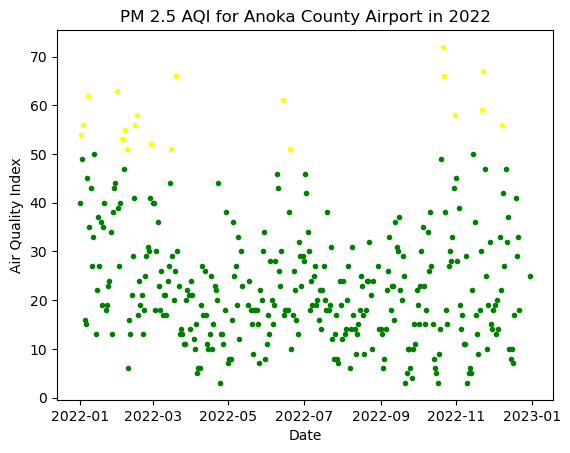

In [8]:
scatter_plot_color(mn_pm25_2022_dict["Anoka_County_Airport_MN_PM_2_5_2022"], "PM 2.5", "Anoka County Airport", 2022)

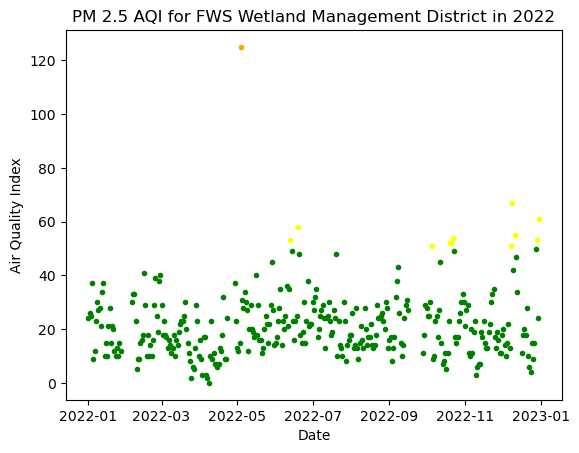

In [9]:
scatter_plot_color(mn_pm25_2022_dict["FWS_Wetland_Management_District_MN_PM_2_5_2022"], "PM 2.5", "FWS Wetland Management District", 2022)

Mapping the locations

In [39]:
# Get coordinates of weather stations

def lat_longs(data_dict):
    locations = list(data_dict.keys())
    lats = []
    longs = []
    coords = []

    for i in range(len(locations)):
        lats.append(data_dict[locations[i]]["Latitude"].unique()[0])
        longs.append(data_dict[locations[i]]["Longitude"].unique()[0])

    coords = list(zip(lats, longs))

    return coords

In [40]:
lat_longs(mn_pm25_2022_dict)

[(45.1376795361548, -93.207614975211),
 (46.851811, -95.846272),
 (47.8781590009383, -95.029172),
 (46.7136940009414, -92.511722),
 (47.3844300009398, -94.60166),
 (47.972085, -89.69098),
 (46.396740000942, -94.1303),
 (44.7384600009432, -93.23725),
 (44.706123, -93.285803),
 (44.9652420009432, -93.254759),
 (44.9536600009432, -93.25821),
 (44.9480500009432, -93.34315),
 (47.948622, -91.495574),
 (44.4438000009431, -95.81789),
 (43.996908, -92.450366),
 (44.9507200009432, -93.09827),
 (44.9593900009432, -93.03587),
 (48.41252, -92.829225),
 (47.5233550009394, -92.536305),
 (46.8182600009412, -92.08936),
 (46.7436571531727, -92.1659975412758),
 (44.7914370009432, -93.512534),
 (45.549839, -94.13345),
 (43.9372988088585, -91.405348477261),
 (45.2091600009432, -93.66921)]